In [4]:
# load the dataset
base_dir = r"D:\2023springcourses\CS6665\cs6665 course project\data"
for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\2023springcourses\CS6665\cs6665 course project\data\stock_list.csv
D:\2023springcourses\CS6665\cs6665 course project\data\data_specifications\options_spec.csv
D:\2023springcourses\CS6665\cs6665 course project\data\data_specifications\stock_fin_spec.csv
D:\2023springcourses\CS6665\cs6665 course project\data\data_specifications\stock_list_spec.csv
D:\2023springcourses\CS6665\cs6665 course project\data\data_specifications\stock_price_spec.csv
D:\2023springcourses\CS6665\cs6665 course project\data\data_specifications\trades_spec.csv
D:\2023springcourses\CS6665\cs6665 course project\data\example_test_files\financials.csv
D:\2023springcourses\CS6665\cs6665 course project\data\example_test_files\options.csv
D:\2023springcourses\CS6665\cs6665 course project\data\example_test_files\sample_submission.csv
D:\2023springcourses\CS6665\cs6665 course project\data\example_test_files\secondary_stock_prices.csv
D:\2023springcourses\CS6665\cs6665 course project\data\example_test_files\stock_prices.csv

In [3]:
#import os
#os.chdir("/kaggle/input/jpx-tokyo-stock-exchange-prediction")

In [21]:
##import libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import xgboost as xgb
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from scipy import stats
#import jpx_tokyo_market_prediction
import warnings; warnings.filterwarnings("ignore")

## 1. Understand how to calculate scores and deepen your understanding of Rank ##
https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition
https://www.kaggle.com/code/chumajin/easy-to-understand-the-competition?scriptVersionId=94143164

In [5]:
# look for the stock_prices.csv in train file
stock_prices=pd.read_csv(f"{base_dir}/train_files"+'/stock_prices.csv')
stock_prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [6]:
stock_prices["Date"] = pd.to_datetime(stock_prices["Date"])

In [7]:
# look for only one stock,eg.1301
tmpdf = stock_prices[stock_prices["SecuritiesCode"]==1301].reset_index(drop=True)
tmpdf.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092


In [8]:
 # calculate TARGET (change rate of Close on the next day and the next day) by yourself.
tmpdf["Close_shift1"] = tmpdf["Close"].shift(-1)
tmpdf["Close_shift2"] = tmpdf["Close"].shift(-2)

tmpdf["rate"] = (tmpdf["Close_shift2"] - tmpdf["Close_shift1"]) / tmpdf["Close_shift1"]
tmpdf

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Close_shift1,Close_shift2,rate
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,2738.0,2740.0,0.000730
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,2740.0,2748.0,0.002920
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,2748.0,2745.0,-0.001092
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,2745.0,2731.0,-0.005100
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,2731.0,2722.0,-0.003295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,20211129_1301,2021-11-29,1301,2975.0,2984.0,2951.0,2951.0,14300,1.0,NaN,False,0.003793,2900.0,2911.0,0.003793
1198,20211130_1301,2021-11-30,1301,2953.0,2997.0,2900.0,2900.0,20500,1.0,NaN,False,0.007558,2911.0,2933.0,0.007558
1199,20211201_1301,2021-12-01,1301,2909.0,2936.0,2909.0,2911.0,10600,1.0,NaN,False,0.016706,2933.0,2982.0,0.016706
1200,20211202_1301,2021-12-02,1301,2949.0,2973.0,2933.0,2933.0,15200,1.0,NaN,False,-0.003689,2982.0,NaN,NaN


the Target and the rate calculated match. (so I will use the Target that is calculated from now on)

## Rank calculation. ##
First, let's take a look at only one day. * Please note that not all 2000 stocks have data depending on the date.

In [9]:
tmpdf2 = stock_prices[stock_prices["Date"]=="2021-12-03"].reset_index(drop=True)
tmpdf2

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211203_1301,2021-12-03,1301,2983.0,2983.0,2965.0,2982.0,11400,1.0,NaN,False,0.031639
1,20211203_1332,2021-12-03,1332,579.0,585.0,570.0,585.0,1195500,1.0,NaN,False,-0.056027
2,20211203_1333,2021-12-03,1333,2333.0,2358.0,2315.0,2358.0,103200,1.0,NaN,False,0.013462
3,20211203_1375,2021-12-03,1375,1222.0,1236.0,1218.0,1235.0,69900,1.0,NaN,False,0.032680
4,20211203_1376,2021-12-03,1376,1370.0,1370.0,1321.0,1332.0,5000,1.0,NaN,False,0.032568
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
1996,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
1997,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
1998,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


Rank in descending order of Target. I do sort it for understanding. Rank is tied to 0-1999, so don't forget -1 

In [10]:
tmpdf2["rank"] = tmpdf2["Target"].rank(ascending=False,method="first") -1 
tmpdf2 = tmpdf2.sort_values("rank").reset_index(drop=True)
tmpdf2

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank
0,20211203_4699,2021-12-03,4699,2140.0,2180.0,2117.0,2160.0,19700,1.0,NaN,True,0.187970,0.0
1,20211203_1873,2021-12-03,1873,342.0,352.0,340.0,352.0,84200,1.0,NaN,False,0.186782,1.0
2,20211203_6779,2021-12-03,6779,1558.0,1582.0,1489.0,1546.0,519200,1.0,NaN,False,0.159624,2.0
3,20211203_7809,2021-12-03,7809,6060.0,6430.0,5830.0,6410.0,46300,1.0,NaN,False,0.136667,3.0
4,20211203_3031,2021-12-03,3031,1191.0,1193.0,1155.0,1155.0,1651500,1.0,NaN,False,0.119069,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20211203_6958,2021-12-03,6958,527.0,528.0,503.0,514.0,436000,1.0,NaN,False,-0.058201,1995.0
1996,20211203_9790,2021-12-03,9790,3825.0,3890.0,3820.0,3860.0,23200,1.0,NaN,False,-0.084321,1996.0
1997,20211203_2158,2021-12-03,2158,3105.0,3245.0,2365.0,2365.0,11828500,1.0,NaN,False,-0.091797,1997.0
1998,20211203_6718,2021-12-03,6718,2156.0,2212.0,2133.0,2194.0,49600,1.0,NaN,False,-0.092211,1998.0


## Calculation of daily spread return of this day ##



In [22]:
tmpdf2_top200 = tmpdf2.iloc[:200,:]
weights = np.linspace(start=2, stop=1, num=200)
tmpdf2_top200["weights"] = weights
tmpdf2_top200["calc_weights"] = tmpdf2_top200["Target"] * tmpdf2_top200["weights"]
Sup = tmpdf2_top200["calc_weights"].sum()/np.mean(weights)
Sup

12.784119119374031

In [23]:
tmpdf2_bottom200 = tmpdf2.iloc[-200:,:]
tmpdf2_bottom200 = tmpdf2_bottom200.sort_values("rank",ascending = False).reset_index(drop=True)
tmpdf2_bottom200["weights"] = weights
tmpdf2_bottom200["calc_weights"] = tmpdf2_bottom200["Target"] * tmpdf2_bottom200["weights"]
Sdown = tmpdf2_bottom200["calc_weights"].sum()/np.mean(weights)
Sdown


-1.6545226418872847

In [24]:
# calculate daily spread return
daily_spread_return = Sup - Sdown
daily_spread_return

14.438641761261316

In [25]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [26]:
# calculate which days have 2000 stocks
idcount = stock_prices.groupby("Date")["SecuritiesCode"].count().reset_index()
idcount

,Date,SecuritiesCode
0,2017-01-04,1865
1,2017-01-05,1865
2,2017-01-06,1865
3,2017-01-10,1865
4,2017-01-11,1865
...,...,...
1197,2021-11-29,2000
1198,2021-11-30,2000
1199,2021-12-01,2000
1200,2021-12-02,2000


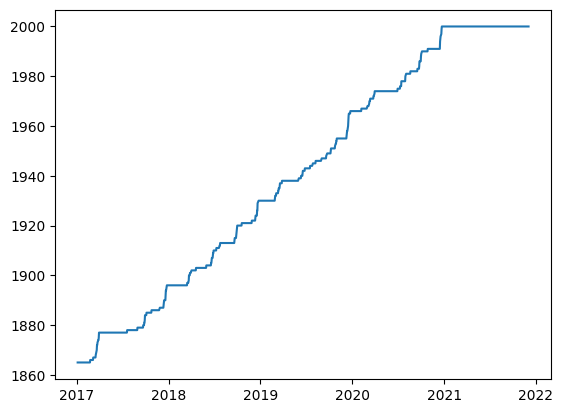

In [27]:
plt.plot(idcount["Date"],idcount["SecuritiesCode"])

In [28]:
idcount.loc[idcount["SecuritiesCode"]==2000,:]

,Date,SecuritiesCode
970,2020-12-23,2000
971,2020-12-24,2000
972,2020-12-25,2000
973,2020-12-28,2000
974,2020-12-29,2000
...,...,...
1197,2021-11-29,2000
1198,2021-11-30,2000
1199,2021-12-01,2000
1200,2021-12-02,2000


In [29]:
stock_prices2 = stock_prices.loc[stock_prices["Date"]>= "2021-01-01"].reset_index(drop=True)
stock_prices2

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20210104_1301,2021-01-04,1301,2951.0,2951.0,2913.0,2950.0,9700,1.0,NaN,False,0.011502
1,20210104_1332,2021-01-04,1332,428.0,429.0,416.0,421.0,1780500,1.0,NaN,False,0.019093
2,20210104_1333,2021-01-04,1333,2229.0,2231.0,2179.0,2202.0,112400,1.0,NaN,False,0.015075
3,20210104_1375,2021-01-04,1375,1701.0,1701.0,1672.0,1674.0,67900,1.0,NaN,False,-0.003503
4,20210104_1376,2021-01-04,1376,1597.0,1597.0,1577.0,1588.0,4500,1.0,NaN,False,-0.012033
...,...,...,...,...,...,...,...,...,...,...,...,...
451995,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
451996,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
451997,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
451998,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [30]:
stock_prices2["Rank"] = stock_prices2.groupby("Date")["Target"].rank(ascending=False,method="first") -1 
stock_prices2["Rank"] =stock_prices2["Rank"].astype("int")
stock_prices2["Rank"].min()
score = calc_spread_return_sharpe(stock_prices2, portfolio_size= 200, toprank_weight_ratio= 2)
score

5.7907451128813605

In [31]:
supplemental_stock_prices=pd.read_csv(f"{base_dir}/supplemental_files"+'/stock_prices.csv')
supplemental_stock_prices["Rank"] = supplemental_stock_prices.groupby("Date")["Target"].rank(ascending=False,method="first") -1
idcount1 = supplemental_stock_prices.groupby("Date")["SecuritiesCode"].count().reset_index()
idcount1.loc[idcount1["SecuritiesCode"]==2000,:]



,Date,SecuritiesCode
0,2021-12-06,2000
1,2021-12-07,2000
2,2021-12-08,2000
3,2021-12-09,2000
4,2021-12-10,2000
...,...,...
89,2022-04-18,2000
90,2022-04-19,2000
91,2022-04-20,2000
92,2022-04-21,2000


In [32]:
finday = supplemental_stock_prices[supplemental_stock_prices["Date"]=="2022-04-22"].reset_index(drop=True)
finday

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Rank
0,20220422_1301,2022-04-22,1301,3230.0,3245.0,3215.0,3245.0,12100,1.0,NaN,False,0.013975,449.0
1,20220422_1332,2022-04-22,1332,567.0,571.0,557.0,568.0,1687300,1.0,NaN,False,0.008897,671.0
2,20220422_1333,2022-04-22,1333,2373.0,2386.0,2364.0,2375.0,120600,1.0,NaN,False,0.009750,628.0
3,20220422_1375,2022-04-22,1375,1125.0,1127.0,1108.0,1113.0,90800,1.0,NaN,False,-0.001866,1368.0
4,20220422_1376,2022-04-22,1376,1653.0,1657.0,1629.0,1629.0,8800,1.0,NaN,False,-0.009412,1736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20220422_9990,2022-04-22,9990,491.0,491.0,486.0,488.0,18900,1.0,NaN,False,0.008214,710.0
1996,20220422_9991,2022-04-22,9991,787.0,794.0,783.0,794.0,12500,1.0,NaN,False,-0.002561,1409.0
1997,20220422_9993,2022-04-22,9993,1552.0,1563.0,1551.0,1557.0,1600,1.0,NaN,False,0.012338,512.0
1998,20220422_9994,2022-04-22,9994,2454.0,2464.0,2451.0,2451.0,4600,1.0,NaN,False,0.004965,901.0


In [33]:
finday[finday["Rank"]==finday["Rank"].iloc[0]]
#finday["Rank"] = finday["Rank"].astype("int")
findaydict = dict(zip(finday["SecuritiesCode"],finday["Rank"]))

In [36]:
#sample_prediction["Rank"]  = sample_prediction["SecuritiesCode"].map(findaydict)
#sample_prediction

In [34]:
stock_prices=pd.read_csv(f"{base_dir}/train_files"+'/stock_prices.csv')
secondary_stock_prices=pd.read_csv(f"{base_dir}/train_files"+'/secondary_stock_prices.csv')
supplemental_stock_prices=pd.read_csv(f"{base_dir}/supplemental_files"+'/stock_prices.csv')
supplemental_secondary_stock_prices=pd.read_csv(f"{base_dir}/supplemental_files"+'/secondary_stock_prices.csv')

In [37]:
stock_prices.head(-5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332521,20211203_9982,2021-12-03,9982,1720.0,1748.0,1715.0,1746.0,8800,1.0,NaN,False,0.017065
2332522,20211203_9983,2021-12-03,9983,66010.0,67000.0,65380.0,66650.0,860900,1.0,NaN,False,0.000737
2332523,20211203_9984,2021-12-03,9984,5570.0,5637.0,5423.0,5559.0,25516400,1.0,NaN,False,0.079365
2332524,20211203_9987,2021-12-03,9987,3105.0,3180.0,3065.0,3175.0,214000,1.0,NaN,False,0.026856


In [38]:
secondary_stock_prices.head(-5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1305,2017-01-04,1305,1594.0,1618.0,1594.0,1615.0,538190,1.0,NaN,False,-0.001855
1,20170104_1306,2017-01-04,1306,1575.0,1595.0,1573.0,1593.0,2494980,1.0,NaN,False,-0.000627
2,20170104_1308,2017-01-04,1308,1557.0,1580.0,1557.0,1578.0,526100,1.0,NaN,False,-0.001900
3,20170104_1309,2017-01-04,1309,28810.0,29000.0,28520.0,28780.0,403,1.0,NaN,False,0.005237
4,20170104_1311,2017-01-04,1311,717.0,735.0,717.0,734.0,5470,1.0,NaN,False,0.001359
...,...,...,...,...,...,...,...,...,...,...,...,...
2384565,20211203_9969,2021-12-03,9969,237.0,239.0,237.0,239.0,5000,1.0,NaN,False,-0.008439
2384566,20211203_9972,2021-12-03,9972,298.0,305.0,298.0,303.0,40400,1.0,NaN,False,0.036424
2384567,20211203_9973,2021-12-03,9973,35.0,37.0,35.0,36.0,2029700,1.0,NaN,False,0.000000
2384568,20211203_9976,2021-12-03,9976,1652.0,1721.0,1652.0,1721.0,400,1.0,NaN,False,-0.034483


In [39]:
supplemental_stock_prices.head(-5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False,-0.015032
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False,0.002867
...,...,...,...,...,...,...,...,...,...,...,...,...
269871,20220624_9982,2022-06-24,9982,1050.0,1052.0,990.0,990.0,18600,1.0,NaN,False,-0.001992
269872,20220624_9983,2022-06-24,9983,70810.0,71270.0,69420.0,70440.0,687100,1.0,NaN,False,0.007134
269873,20220624_9984,2022-06-24,9984,5145.0,5249.0,5107.0,5224.0,14084400,1.0,NaN,False,-0.000738
269874,20220624_9987,2022-06-24,9987,3835.0,3835.0,3790.0,3825.0,135100,1.0,NaN,False,0.019815


In [40]:
supplemental_secondary_stock_prices.head(-5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1305,2021-12-06,1305,2061.5,2065.0,2041.5,2048.0,104900,1.0,NaN,False,0.005013
1,20211206_1306,2021-12-06,1306,2037.0,2041.0,2018.5,2025.0,1427480,1.0,NaN,False,0.005793
2,20211206_1308,2021-12-06,1308,2016.0,2019.5,1997.5,2004.5,110000,1.0,NaN,False,0.005367
3,20211206_1309,2021-12-06,1309,43400.0,43710.0,43030.0,43190.0,323,1.0,NaN,False,0.005927
4,20211206_1311,2021-12-06,1311,952.1,953.4,943.5,947.5,2030,1.0,NaN,False,0.006300
...,...,...,...,...,...,...,...,...,...,...,...,...
284573,20220624_9969,2022-06-24,9969,207.0,208.0,206.0,206.0,2500,1.0,NaN,False,-0.004831
284574,20220624_9972,2022-06-24,9972,237.0,239.0,236.0,237.0,12400,1.0,NaN,False,0.004184
284575,20220624_9973,2022-06-24,9973,29.0,32.0,29.0,31.0,2871400,1.0,NaN,False,0.000000
284576,20220624_9976,2022-06-24,9976,1756.0,1756.0,1756.0,1756.0,1400,1.0,NaN,False,-0.017483


In [45]:
# join the datas in the train file and supplemental files
stock_prices = stock_prices.append(secondary_stock_prices)
stock_prices = stock_prices.append(supplemental_stock_prices)
stock_prices= stock_prices.append(supplemental_secondary_stock_prices)
stock_prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
284578,20220624_9980,2022-06-24,9980,111.0,111.0,109.0,110.0,88000,1.0,NaN,False,-0.009009
284579,20220624_9986,2022-06-24,9986,1862.0,1913.0,1862.0,1913.0,3500,1.0,NaN,False,-0.007495
284580,20220624_9995,2022-06-24,9995,402.0,404.0,400.0,402.0,16000,1.0,NaN,False,0.004950
284581,20220624_9996,2022-06-24,9996,1281.0,1281.0,1231.0,1241.0,1700,1.0,NaN,False,0.000806


In [46]:
stock_prices.head(-5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
284573,20220624_9969,2022-06-24,9969,207.0,208.0,206.0,206.0,2500,1.0,NaN,False,-0.004831
284574,20220624_9972,2022-06-24,9972,237.0,239.0,236.0,237.0,12400,1.0,NaN,False,0.004184
284575,20220624_9973,2022-06-24,9973,29.0,32.0,29.0,31.0,2871400,1.0,NaN,False,0.000000
284576,20220624_9976,2022-06-24,9976,1756.0,1756.0,1756.0,1756.0,1400,1.0,NaN,False,-0.017483


In [43]:
stock_prices_supple.head(-5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False,-0.015032
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False,0.002867
...,...,...,...,...,...,...,...,...,...,...,...,...
284573,20220624_9969,2022-06-24,9969,207.0,208.0,206.0,206.0,2500,1.0,NaN,False,-0.004831
284574,20220624_9972,2022-06-24,9972,237.0,239.0,236.0,237.0,12400,1.0,NaN,False,0.004184
284575,20220624_9973,2022-06-24,9973,29.0,32.0,29.0,31.0,2871400,1.0,NaN,False,0.000000
284576,20220624_9976,2022-06-24,9976,1756.0,1756.0,1756.0,1756.0,1400,1.0,NaN,False,-0.017483


## Features Analysis ##

In [86]:
# Convert 'Date' column to datetime type
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])

# Get the data in the year 2021 
stock_prices2021 = stock_prices[stock_prices['Date'] > pd.to_datetime('2021-01-01')]

stock_prices2021=stock_prices2021.drop(columns=['RowId','Date','SecuritiesCode','ExpectedDividend','SupervisionFlag'])

stock_prices2021

,Open,High,Low,Close,Volume,AdjustmentFactor,Target
1880531,2951.0,2951.0,2913.0,2950.0,9700,1.0,0.011502
1880532,428.0,429.0,416.0,421.0,1780500,1.0,0.019093
1880533,2229.0,2231.0,2179.0,2202.0,112400,1.0,0.015075
1880534,1701.0,1701.0,1672.0,1674.0,67900,1.0,-0.003503
1880535,1597.0,1597.0,1577.0,1588.0,4500,1.0,-0.012033
...,...,...,...,...,...,...,...
284578,111.0,111.0,109.0,110.0,88000,1.0,-0.009009
284579,1862.0,1913.0,1862.0,1913.0,3500,1.0,-0.007495
284580,402.0,404.0,400.0,402.0,16000,1.0,0.004950
284581,1281.0,1281.0,1231.0,1241.0,1700,1.0,0.000806


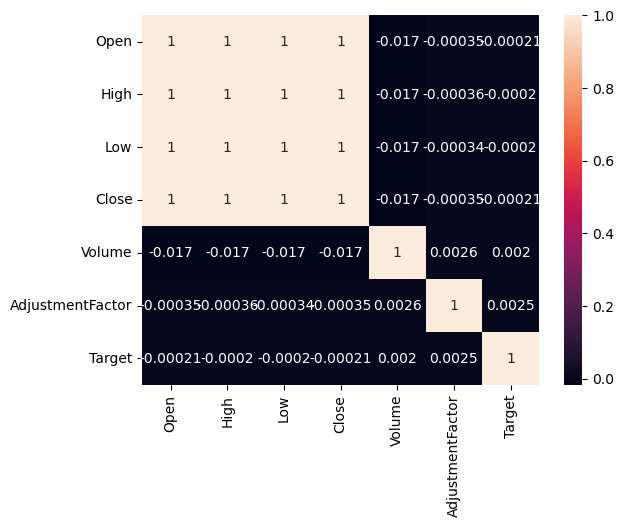

In [87]:
# calculate the correlations about features
sns.heatmap(stock_prices2021.corr(), annot=True)
plt.show()

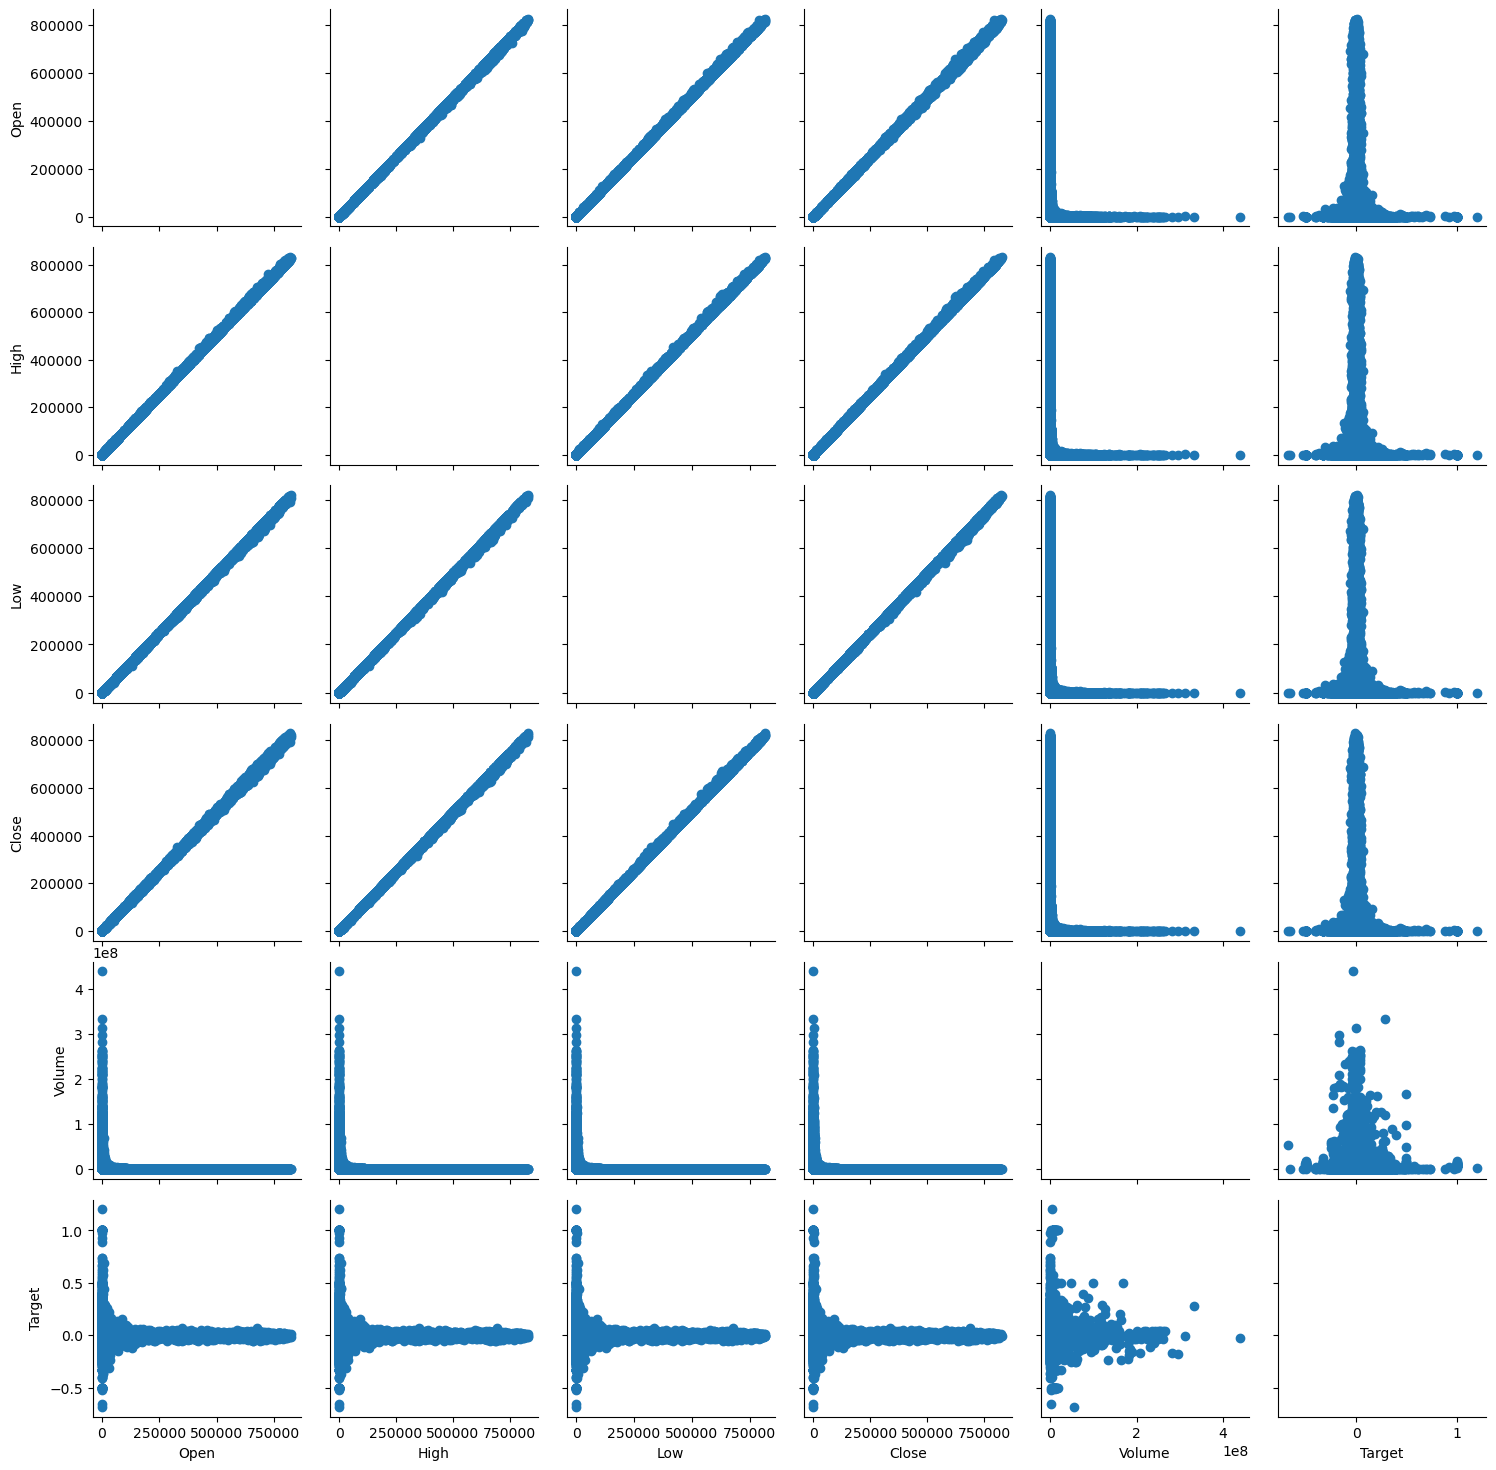

In [90]:
g = sns.PairGrid(data = stock_prices2021, vars = ['Open', 'High', 'Low','Close','Volume','Target'])
g.map_offdiag(plt.scatter)

1. from the graphs we can see the features(Open,High,Low,Close) are postive correlation.
2. The relationshio between the features(Open,High,Low,Close,Volume) and target presents a normal distribution.

1. from the stock_prices.cvs, we can know that the values of ExpectedDividend are nan, so we will set  the value to zero.
2. the values of SupervisionFlag is binary, so we change them to int.
3. if some values of target are missing, we will set 0 to them.
4.we will choose the features:'Open', 'High', 'Low', 'Close'. becase In investing and trading, Z-scores are measures of an instrument's variability and can be used by traders to help determine volatility. so we will use zscore to scale the values.

In [91]:
def feature_engineering(data):
    data['ExpectedDividend'] = data['ExpectedDividend'].fillna(0)
    data["SupervisionFlag"] = data["SupervisionFlag"].astype(int)
    data['Target'] = data['Target'].fillna(0)
    
    cols = ['Open', 'High', 'Low', 'Close']
    data.loc[:,cols] = data.loc[:,cols].ffill()
    data.loc[:,cols] = data.loc[:,cols].bfill()

    

    data['Open'] = stats.zscore(data['Open'])
    data['High'] = stats.zscore(data['High'])
    data['Low'] = stats.zscore(data['Low'])
    data['Close'] = stats.zscore(data['Close'])
   
    
    data = data.drop(['RowId', 'Date'], axis=1)
    
    return data

In [103]:
def featuring_2(data):
    data['ExpectedDividend'] = data['ExpectedDividend'].fillna(0)
    data["SupervisionFlag"] = data["SupervisionFlag"].astype(int)
    
    cols = ['Open', 'High', 'Low', 'Close']
    data.loc[:,cols] = data.loc[:,cols].ffill()
    data.loc[:,cols] = data.loc[:,cols].bfill()

    
    
    data['Open'] = stats.zscore(data['Open'])
    data['High'] = stats.zscore(data['High'])
    data['Low'] = stats.zscore(data['Low'])
    data['Close'] = stats.zscore(data['Close'])
   
    
    data = data.drop(['RowId', 'Date','Target'], axis=1)
    
    return data

In [92]:
df=feature_engineering(stock_prices)
df

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,1301,-0.089035,-0.089252,-0.088276,-0.088774,31400,1.0,0.0,0,0.000730
1,1332,-0.150313,-0.150384,-0.150109,-0.150198,2798500,1.0,0.0,0,0.012324
2,1333,-0.077267,-0.076487,-0.076577,-0.075533,270800,1.0,0.0,0,0.006154
3,1376,-0.123663,-0.123059,-0.123087,-0.122499,11300,1.0,0.0,0,0.011053
4,1377,-0.073872,-0.072559,-0.072867,-0.072138,150800,1.0,0.0,0,0.003026
...,...,...,...,...,...,...,...,...,...,...
284578,9980,-0.163242,-0.163430,-0.163064,-0.163241,88000,1.0,0.0,0,-0.009009
284579,9986,-0.113705,-0.112874,-0.113043,-0.112229,3500,1.0,0.0,0,-0.007495
284580,9995,-0.155009,-0.155210,-0.154760,-0.154980,16000,1.0,0.0,0,0.004950
284581,9996,-0.130142,-0.130605,-0.131049,-0.131242,1700,1.0,0.0,0,0.000806


In [93]:
df_1=df.drop(['Target'],axis=1)
df_1.shape


(5271570, 9)

## create models ##

generate train set and test set

In [94]:
df_X=df.drop(['Target'], axis=1)
df_Y=df['Target']

In [95]:
df_X.head()

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag
0,1301,-0.089035,-0.089252,-0.088276,-0.088774,31400,1.0,0.0,0
1,1332,-0.150313,-0.150384,-0.150109,-0.150198,2798500,1.0,0.0,0
2,1333,-0.077267,-0.076487,-0.076577,-0.075533,270800,1.0,0.0,0
3,1376,-0.123663,-0.123059,-0.123087,-0.122499,11300,1.0,0.0,0
4,1377,-0.073872,-0.072559,-0.072867,-0.072138,150800,1.0,0.0,0


In [96]:
df_Y.head()

0    0.000730
1    0.012324
2    0.006154
3    0.011053
4    0.003026
Name: Target, dtype: float64

In [97]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X,df_Y, test_size=0.2, random_state=42)

In [98]:
X_train.shape,X_test.shape

((4217256, 9), (1054314, 9))

## model 1 : Linear regression ##

In [99]:
from sklearn.linear_model import LinearRegression

# Create an instance of the LinearRegression class
model_reg = LinearRegression()

# Train the model on the training data
model_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model_reg.predict(X_test)

# print the parameters
print(model_reg.coef_) 
print(model_reg.intercept_) 
print(model_reg.get_params())

[-1.31345447e-08  2.35158932e-04  1.64527768e-02  1.32503793e-02
 -2.99532068e-02 -1.58020162e-11 -6.32870948e-05 -3.99775201e-06
  5.81486396e-04]
0.0004563701613193061
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}


In [100]:
y_pred

array([0.00029774, 0.00033069, 0.00026377, ..., 0.00028752, 0.00038951,
       0.00326652])

In [101]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
mse

0.0006809645115383172

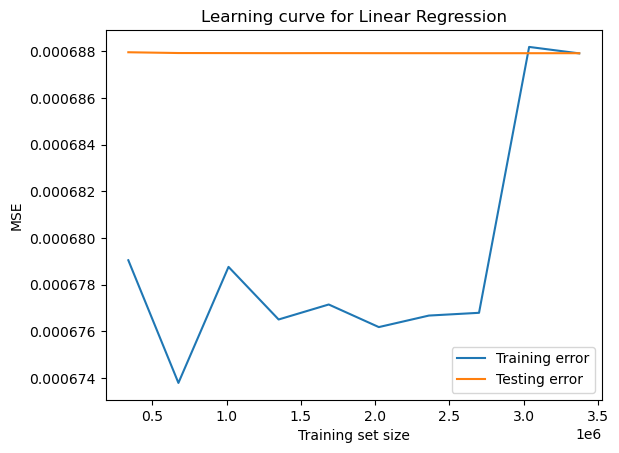

In [102]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=LinearRegression(), 
    X=X_train, 
    y=y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5, 
    scoring='neg_mean_squared_error'
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Testing error')
plt.xlabel('Training set size')
plt.ylabel('MSE')
plt.title('Learning curve for Linear Regression')
plt.legend()
plt.show()

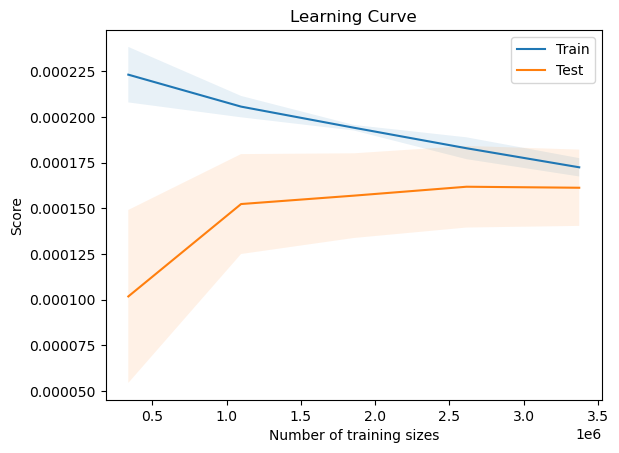

In [104]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Generate the learning curve
train_sizes, train_scores, test_scores = learning_curve(model_reg, X_train, y_train, cv=5)

# Calculate the mean and standard deviation of the training scores and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Train')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Test')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training sizes')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

## model 2: LSTM ##

In [1]:
from keras.wrappers.scikit_learn import KerasRegressor   
from sklearn.model_selection import GridSearchCV

grid_model = Sequential()
grid_model.add(LSTM(50,return_sequences=True,input_shape=(20,9)))
grid_model.add(LSTM(50))
grid_model.add(Dropout(0.2))
grid_model.add(Dense(1))   

grid_model.compile(loss='mse',optimizer = 'adam')
# Reshape input data to have 20 time steps and 9 features
X_train = X_train.values.reshape((X_train.shape[0], 20, 9))
X_test = X_test.values.reshape((X_test.shape[0], 20, 9))
history = grid_model.fit(X_train,y_train,epochs=10,batch_size=30,validation_data=(X_test,y_test))   


NameError: name 'Sequential' is not defined

In [106]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define function to create model
def create_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(30, 9)))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

# Create KerasRegressor wrapper for the model
keras_model = KerasRegressor(build_fn=create_model)

# Define hyperparameters to tune
param_grid = {
    'batch_size': [10, 20, 30],
    'epochs': [10, 20, 30]
}

# Perform grid search using cross-validation
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_train, y_train)

# Print best hyperparameters and corresponding score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/10


ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_112" is incompatible with the layer: expected shape=(None, 30, 9), found shape=(None, 9)


## model 3: LightGBM ##

## model 4:Xgboost ##